# Coastal Kelvin Wave Test Case

simulating a coastal kelvin wave

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/"

In [12]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")
include(CODE_ROOT * "mode_init/exactsolutions.jl")

using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")

using LinearAlgebra # for norm()
import Dates
using DelimitedFiles

In [3]:
function boundaryCondition2!(mpasOcean, t)
    for iEdge in 1:mpasOcean.nEdges
        if mpasOcean.boundaryEdge[iEdge] == 1.0
#             mpasOcean.normalVelocityCurrent[iEdge,:] .= 0
            mpasOcean.normalVelocityCurrent[iEdge,:] .= kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)/mpasOcean.nVertLevels
        end
    end

end

boundaryCondition2! (generic function with 1 method)

In [4]:
function lateralProfilePeriodic(y)
    return 1e-3*cos(y/mpasOcean.lY * 4 * pi)
end
lateralProfile = lateralProfilePeriodic
nvlevels=100
nCellsX = 256
mesh_directory,base_mesh_file_name,mesh_file_name, periodicity = CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
    "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", "NonPeriodic_x"
mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name, periodicity=periodicity, nvlevels=nvlevels)
kelvinWaveExactNormalVelocity, kelvinWaveExactSSH, kelvinWaveExactSolution!, boundaryCondition! = kelvinWaveGenerator(mpasOcean, lateralProfile)

(kelvinWaveExactNormalVelocity, kelvinWaveExactSSH, kelvinWaveExactSolution!, boundaryCondition!)

In [10]:
function kelvin_test(mesh_directory, base_mesh_file_name, mesh_file_name, periodicity, T, dt, nSaves=1;
        plot=false, animate=false, nvlevels=1)
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name, periodicity=periodicity, nvlevels=nvlevels)
#     fixAngleEdge2!(mpasOcean)
    
    meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)
    meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)
    c = sqrt(mpasOcean.gravity*meanFluidThicknessH)
    rossbyRadiusR = c/meanCoriolisParameterf
    
    println("simulating for T: $T")
    lYedge = maximum(mpasOcean.yEdge) - minimum(mpasOcean.yEdge)

    function lateralProfilePeriodic(y)
        return 1e-3*cos(y/mpasOcean.lY * 4 * pi)
    end
    
    period = lYedge / (4*pi) /c

    lateralProfile = lateralProfilePeriodic
    
    println("generating kelvin wave exact methods for mesh")
    kelvinWaveExactNormalVelocity, kelvinWaveExactSSH, kelvinWaveExactSolution!, boundaryCondition! = kelvinWaveGenerator(mpasOcean, lateralProfile)
    
    println("setting up initial condition")
    kelvinWaveExactSolution!(mpasOcean)
    
    
    println("original dt $(mpasOcean.dt)")
    nSteps = Int(round(T/mpasOcean.dt/nSaves))
    mpasOcean.dt = T / nSteps / nSaves
    
    sshOverTimeNumerical = zeros(Float64, (nSaves, mpasOcean.nCells))
    sshOverTimeExact = zeros(Float64, (nSaves, mpasOcean.nCells))
    nvOverTimeExact = zeros(Float64, (nSaves, mpasOcean.nEdges))
    
    println("dx $(mpasOcean.dcEdge[1]) \t dt $(mpasOcean.dt) \t dx/c $(maximum(mpasOcean.dcEdge) / c) \t dx/dt $(mpasOcean.dcEdge[1]/mpasOcean.dt)")
    println("period $period \t steps $nSteps")
    
    t = 0
    for i in 1:nSaves
        for j in 1:nSteps
            
            calculate_normal_velocity_tendency!(mpasOcean)
            update_normal_velocity_by_tendency!(mpasOcean)

            boundaryCondition2!(mpasOcean, t)
#             mpasOcean.normalVelocityCurrent[mpasOcean.boundaryEdge] .= 0
#             for iEdge in 1:mpasOcean.nEdges
#                 if mpasOcean.boundaryEdge[iEdge] == 1.0
#                     mpasOcean.normalVelocityCurrent[iEdge,:] .= 0# kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
#                 end
#             end

            calculate_ssh_tendency!(mpasOcean)
            update_ssh_by_tendency!(mpasOcean)
            
            t += mpasOcean.dt
        end
        print("t: $t")
        sshOverTimeNumerical[i,:] .= mpasOcean.sshCurrent[:]
        sshOverTimeExact[i,:] .= kelvinWaveExactSSH(mpasOcean, collect(1:mpasOcean.nCells), t)
        nvOverTimeExact[i,:] .= kelvinWaveExactNormalVelocity(mpasOcean, collect(1:mpasOcean.nEdges), t)
    end
    
    
    
    if plot
        
        fig, axs = plt.subplots(2,3, figsize=(9,9))
        
        _, ax, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent, fig=fig, ax=axs[1,1])
        ax.set_title("Numerical Solution")

        _, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:], fig=fig, ax=axs[1,2])
        ax.set_title("Exact Solution")
        
        _, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:] - sshOverTimeNumerical[end,:], fig=fig, ax=axs[1,3])#, cMin=-0.005, cMax=0.005)
        ax.set_title("Difference")
        
        
        
        _, ax, _ = edgeHeatMapMesh(mpasOcean, mpasOcean.normalVelocityCurrent, fig=fig, ax=axs[2,1])
        ax.set_title("Numerical Solution")

        _, ax, _ = edgeHeatMapMesh(mpasOcean, nvOverTimeExact[end,:], fig=fig, ax=axs[2,2])
        ax.set_title("Exact Solution")
        
        _, ax, _ = edgeHeatMapMesh(mpasOcean, nvOverTimeExact[end,:] - mpasOcean.normalVelocityCurrent[:,1], fig=fig, ax=axs[2,3])
        ax.set_title("Difference")
        
        fig.suptitle("Coastal Kelvin Wave, T = $(t)")
        display(fig)
        
        if nSaves > 1 && animate
            function update(f)
                i = f+1
                heatMapMesh(mpasOcean, sshOverTimeNumerical[i,:], fig=fig, ax=axs[1,1])
                heatMapMesh(mpasOcean, sshOverTimeExact[i,:], fig=fig, ax=axs[1,2])
                heatMapMesh(mpasOcean, sshOverTimeExact[i,:] - sshOverTimeNumerical[i,:], fig=fig, ax=axs[1,3])
                fig.suptitle("T = $(i*nSteps*mpasOcean.dt)")
            end
            
            anim = animation.FuncAnimation(fig, update, frames=nSaves, interval=100)
            println("writing animation")
            fname = "/tmp/myanimation.gif"
            anim.save(fname)
            display("text/html", """<img src="$fname">""")#="""<video alt="test" controls>
                  <source src="/tmp/myanimation.gif" type="video/mp4">
                  </video>""")=#
        end
    end
    
    error = sshOverTimeNumerical .- sshOverTimeExact
    MaxErrorNorm = norm(error, Inf)
    L2ErrorNorm = norm(error/sqrt(float(mpasOcean.nCells)))
    
    return mpasOcean.nCells, mpasOcean.dt, MaxErrorNorm, L2ErrorNorm
end

kelvin_test (generic function with 2 methods)

simulating for T: 10000
generating kelvin wave exact methods for mesh
setting up initial condition
original dt 78.91816754314067
dx 78125.00000000003 	 dt 83.33333333333334 	 dx/c 789.1816754314227 	 dx/dt 937.5000000000002
period 3480.789291221768 	 steps 6
t: 500.0000000000001t: 1000.0000000000003t: 1500.0t: 1999.9999999999995t: 2500.0000000000005t: 3000.0000000000014t: 3500.0000000000023t: 4000.000000000003t: 4500.000000000002t: 5000.0t: 5499.999999999998t: 5999.999999999996t: 6499.9999999999945t: 6999.999999999993t: 7499.999999999991t: 7999.999999999989t: 8499.99999999999t: 8999.999999999995t: 9499.999999999998t: 10000.000000000002

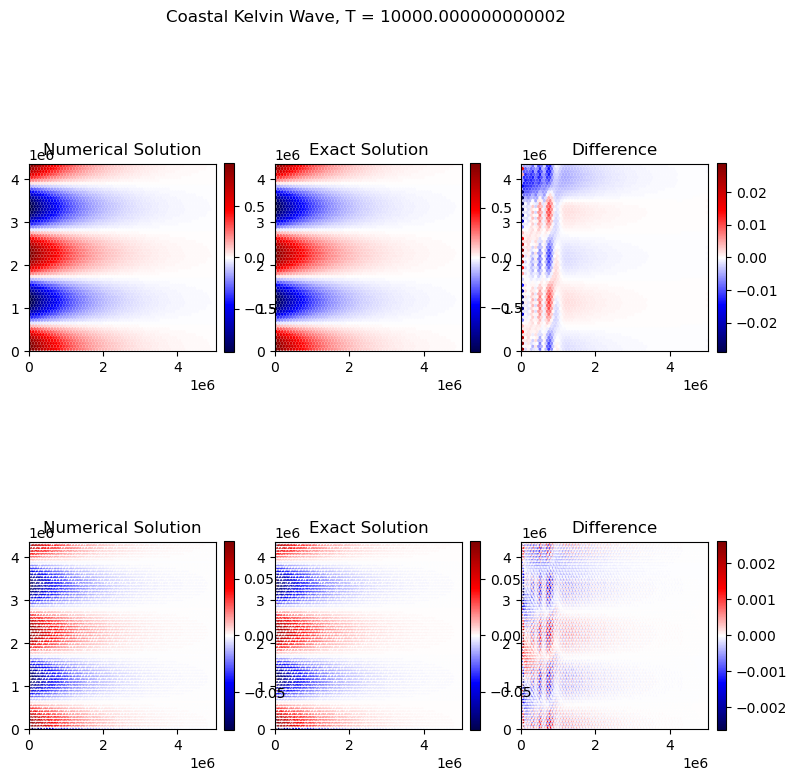

writing animation


MovieWriter ffmpeg unavailable; using Pillow instead.


(4096, 83.33333333333334, 0.0398399972449599, 0.013085133489434145)

In [11]:
T = 10000
nCellsX = 64
nCells, dt, MaxErrorNorm, L2ErrorNorm = kelvin_test(
    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
    "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", "NonPeriodic_x", T, 75, 20, plot=true, animate=true, nvlevels=1)

simulating for T: 7000
generating kelvin wave exact methods for mesh
setting up initial condition
original dt 78.91816754314067
dx 78125.00000000003 	 dt 78.65168539325843 	 dx/c 789.1816754314227 	 dx/dt 993.3035714285717
period 3480.789291221768 	 steps 89


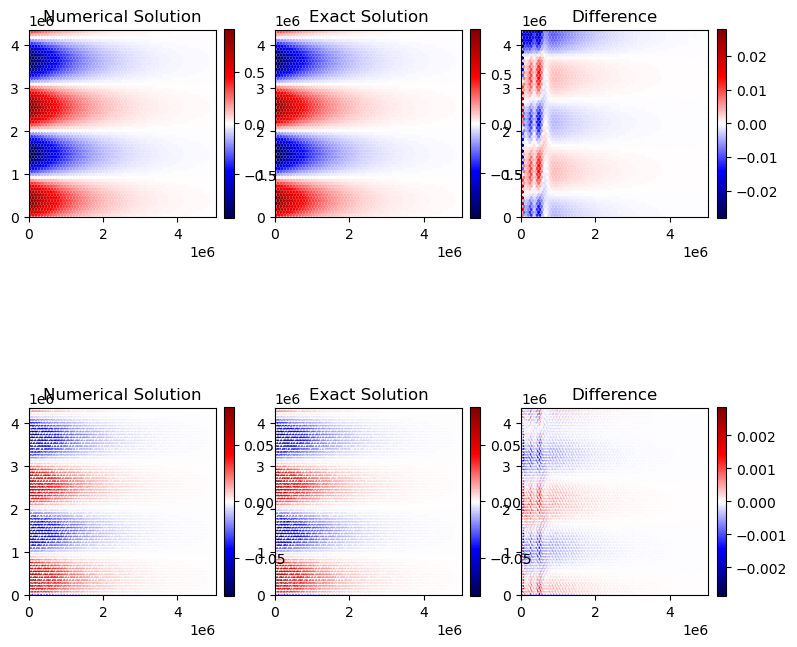

(4096, 78.65168539325843, 0.027987536756909237, 0.003226832264703286)

In [9]:
T = 7000
nCellsX = 64
kelvin_test(
    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
    "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", "NonPeriodic_x", T, 75, plot=true, nvlevels=1)

In [17]:
function wrap_regex(str::AbstractString, maxlen = 92)
    replace(str, Regex(".{1,$maxlen}( |\$)") => @s_str "\\0\n")
end

function convergenceplot(nCellsX, errorNorm, normtype, T, decimals)
    A = [log10.(nCellsX)    ones(length(nCellsX))]
    m, c = A \ log10.(errorNorm)
    y = m*log10.(nCellsX) .+ c
    y = 10 .^ y
    
    slopestr ="$(round(m,digits=decimals))"
    while length(split(slopestr, ".")[end]) < decimals
        slopestr *= "0"
    end

    fig, ax = subplots(1,1, figsize=(9,9))
    tight_layout()
    ax.loglog(nCellsX, errorNorm, label="$normtype Error Norm", marker="s", linestyle="None", color="black")
    ax.loglog(nCellsX, y, label="Best Fit Line, slope=$slopestr", color="black")
    ax.set_title(wrap_regex("Convergence of $normtype Error Norm of Coastal Kelvin Wave, Time Horizon = $(T) s", 50), fontsize=22, fontweight="bold")
    ax.legend(loc="upper right", fontsize=20)
    ax.set_xlabel("Number of cells", fontsize=20)
    ax.set_ylabel("$normtype error norm", fontsize=20)
    ax.grid(which="both")
    display(fig)
    
    return fig, ax
end

convergenceplot (generic function with 1 method)

In [18]:
function convergence_test(periodicity, mesh_directory, operator_name, test, device;
                write_data=false, show_plots=true, decimals=2, resolutions=[64, 128, 256, 512],
                format=(x->string(x)), nvlevels=1)
    nCases = length(resolutions)
    nCellsX = collect(Int.(round.(resolutions)))
    ncells = zeros(Float64, nCases)
    dts = zeros(Float64, nCases)
    MaxErrorNorm = zeros(Float64, nCases)
    L2ErrorNorm = zeros(Float64, nCases)
    
    # calculate maximum dt
    iCase = argmin(resolutions)
    if periodicity == "Periodic"
        base_mesh_file_name = "base_mesh_$(format(nCellsX[iCase])).nc"
    else
        base_mesh_file_name = "culled_mesh_$(format(nCellsX[iCase])).nc"
    end
    mesh_file_name = "mesh_$(format(nCellsX[iCase])).nc"
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name, periodicity=periodicity, nvlevels=nvlevels)
    
    maxdt = mpasOcean.dt
    T = 32*maxdt
    
    for iCase = 1:nCases
        if periodicity == "Periodic"
            base_mesh_file_name = "base_mesh_$(format(nCellsX[iCase])).nc"
        else
            base_mesh_file_name = "culled_mesh_$(format(nCellsX[iCase])).nc"
        end
        mesh_file_name = "mesh_$(format(nCellsX[iCase])).nc"
        println()
        println("running test $iCase of $nCases, mesh: $mesh_file_name")
        ncells[iCase], dts[iCase], MaxErrorNorm[iCase], L2ErrorNorm[iCase] =
                test(mesh_directory, base_mesh_file_name, mesh_file_name, periodicity, T, maxdt;
                        plot=false, nvlevels=nvlevels)
    end
    
    nCellsX = sqrt.(ncells)
    
    A = [log10.(nCellsX)    ones(length(nCellsX))]
    mmax, cmax = A \ log10.(MaxErrorNorm)
    ymax = mmax*log10.(nCellsX) .+ cmax
    ymax = 10 .^ ymax
    
    
    A = [log10.(nCellsX)    ones(length(nCellsX))]
    ml2, cl2 = A \ log10.(L2ErrorNorm)
    yl2 = ml2*log10.(nCellsX) .+ cl2
    yl2 = 10 .^ yl2
    
    if write_data
        fpath = CODE_ROOT * "output/simulation_convergence/coastal_kelvinwave/$periodicity/$device/timehorizon_$(T)/"
        mkpath(fpath)
        fname = "$fpath$(Dates.now()).txt"
        open(fname, "w") do io
            writedlm(io, [ncells, dts, L2ErrorNorm, MaxErrorNorm])
        end
        println("saved to $fname")
    end
    
    if show_plots
        convergenceplot(nCellsX, MaxErrorNorm, "Maximum", T, 2)
        
        convergenceplot(nCellsX, L2ErrorNorm, "\$L^2\$", T, 2)
    end
end

convergence_test (generic function with 1 method)


running test 1 of 4, mesh: mesh_64x64.nc
simulating for T: 10101.525445522006
generating kelvin wave exact methods for mesh
setting up initial condition
original dt 315.6726701725627
dx 78125.00000000023 	 dt 315.6726701725627 	 dx/c 789.1816754314227 	 dx/dt 247.48737341529485
period 3480.789291221768 	 steps 32
t: 10101.525445522006
running test 2 of 4, mesh: mesh_144x144.nc
simulating for T: 10101.525445522006
generating kelvin wave exact methods for mesh
setting up initial condition
original dt 140.29896452023658
dx 34722.22222199984 	 dt 140.29896452113897 	 dx/c 350.7474113006215 	 dx/dt 247.48737341370904
period 3480.789291199491 	 steps 72
t: 10101.525445522004
running test 3 of 4, mesh: mesh_216x216.nc
simulating for T: 10101.525445522006
generating kelvin wave exact methods for mesh
setting up initial condition
original dt 93.5326430134904
dx 23148.148148000142 	 dt 93.53264301409264 	 dx/c 233.8316075337436 	 dx/dt 247.48737341371174
period 3480.7892911994913 	 steps 108
t:

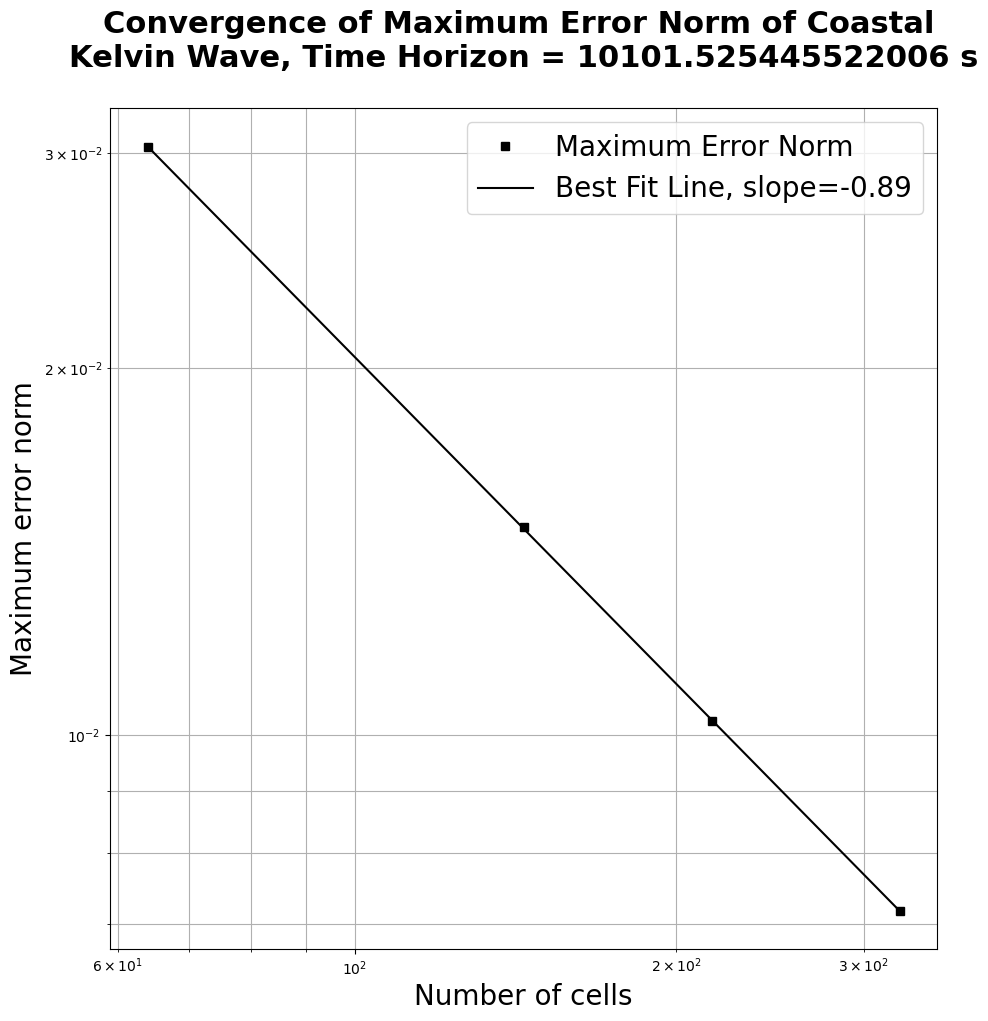

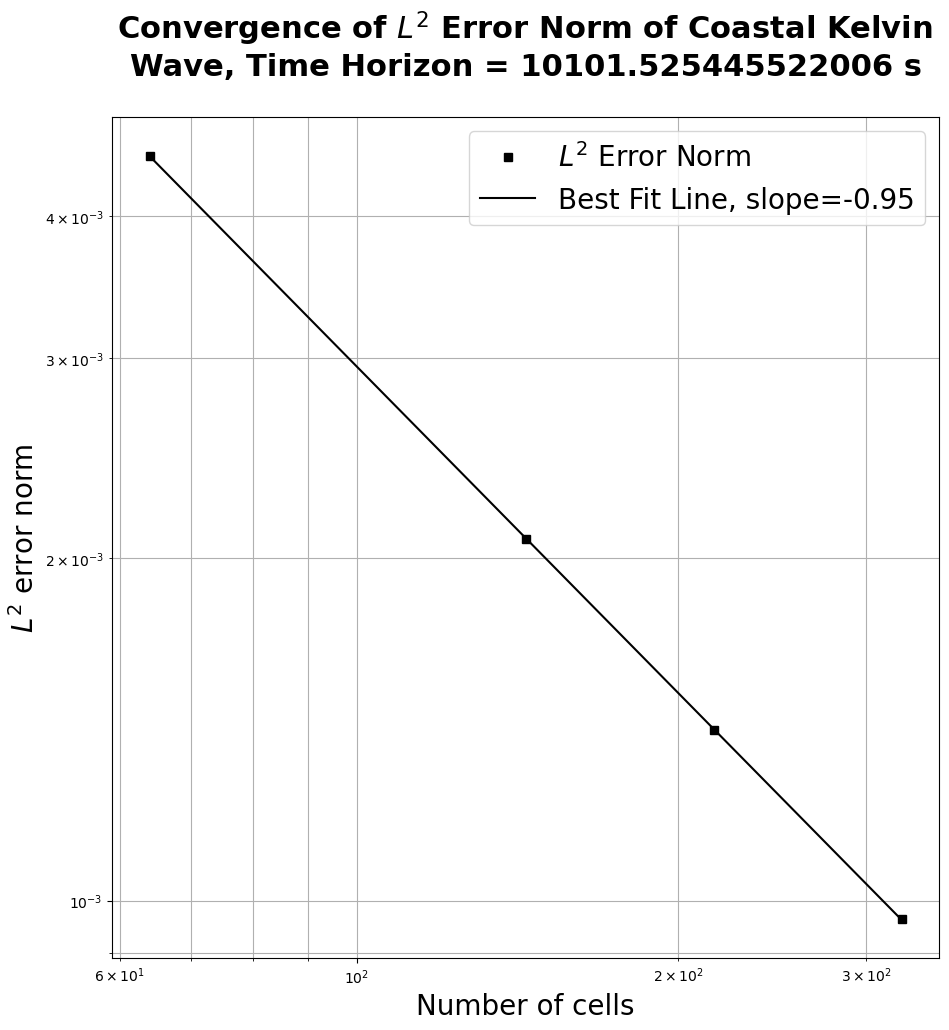

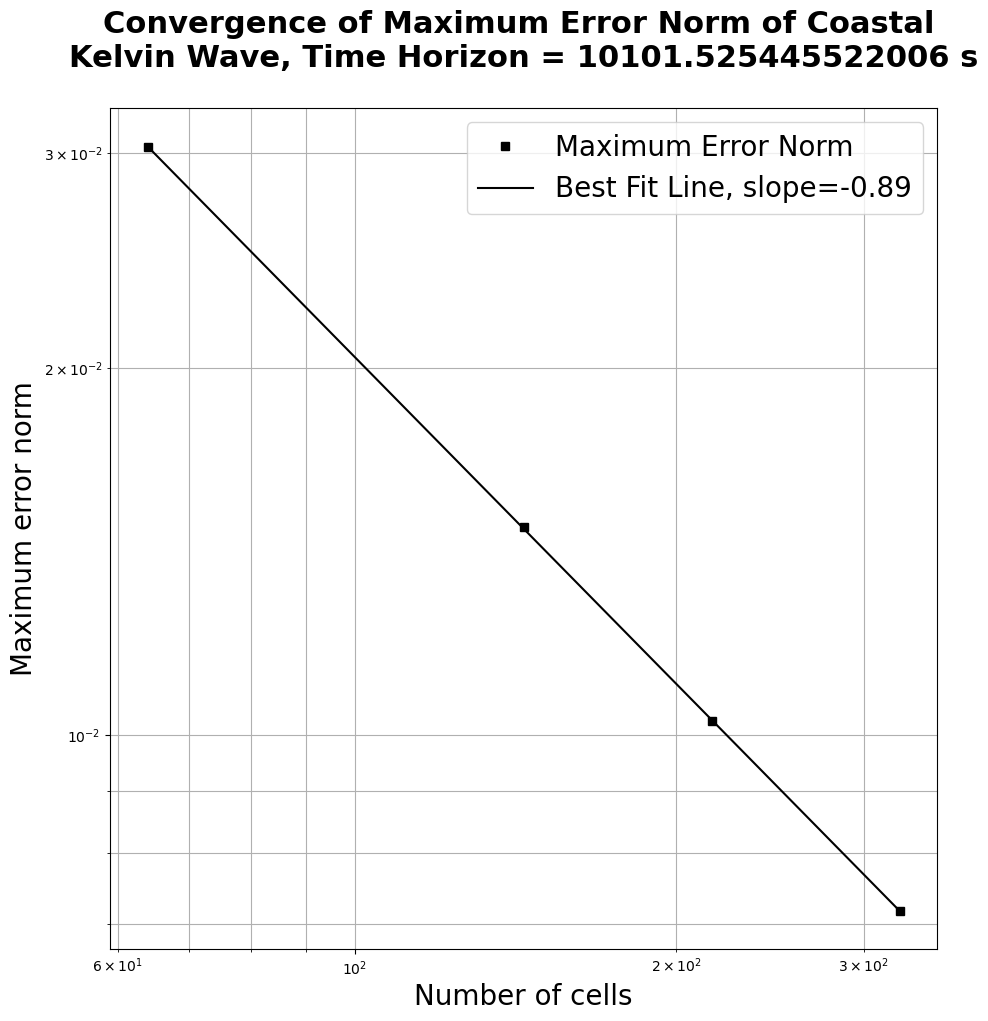

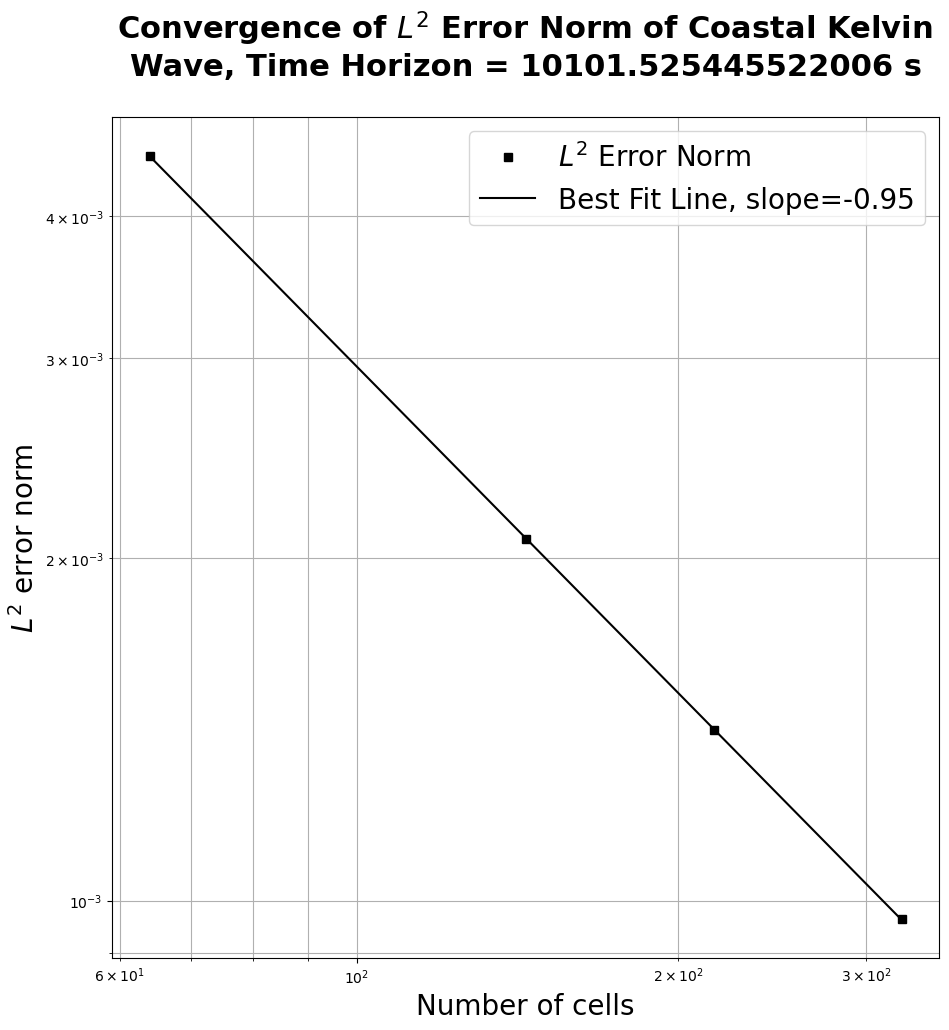

(Figure(PyObject <Figure size 900x900 with 1 Axes>), PyObject <AxesSubplot:title={'center':'Convergence of $L^2$ Error Norm of Coastal Kelvin \nWave, Time Horizon = 10101.525445522006 s\n'}, xlabel='Number of cells', ylabel='$L^2$ error norm'>)

In [19]:
convergence_test("NonPeriodic_x",
            CODE_ROOT * "/ConvergenceStudyMeshes",
            "Coastal Kelvin Wave",
            kelvin_test, "CPU",
            resolutions=[64, 144, 216, 324],
            format=(x->"$(x)x$(x)"),
            write_data=false, show_plots=true, nvlevels=1)

running test 1 of 4
simulating for T: 1600
dx 78125.00000000003
dt 160.0, dx/c 789.1816754314227
period 3480.789291221768
running test 2 of 4
simulating for T: 1600
dx 39062.49999999971
dt 80.0, dx/c 394.59083771571966
period 3480.789291221768
running test 3 of 4
simulating for T: 1600
dx 19531.24999999965
dt 40.0, dx/c 197.29541885785983
period 3480.789291221768
running test 4 of 4
simulating for T: 1600
dx 9765.625
dt 20.0, dx/c 98.64770942892991
period 3480.789291221768


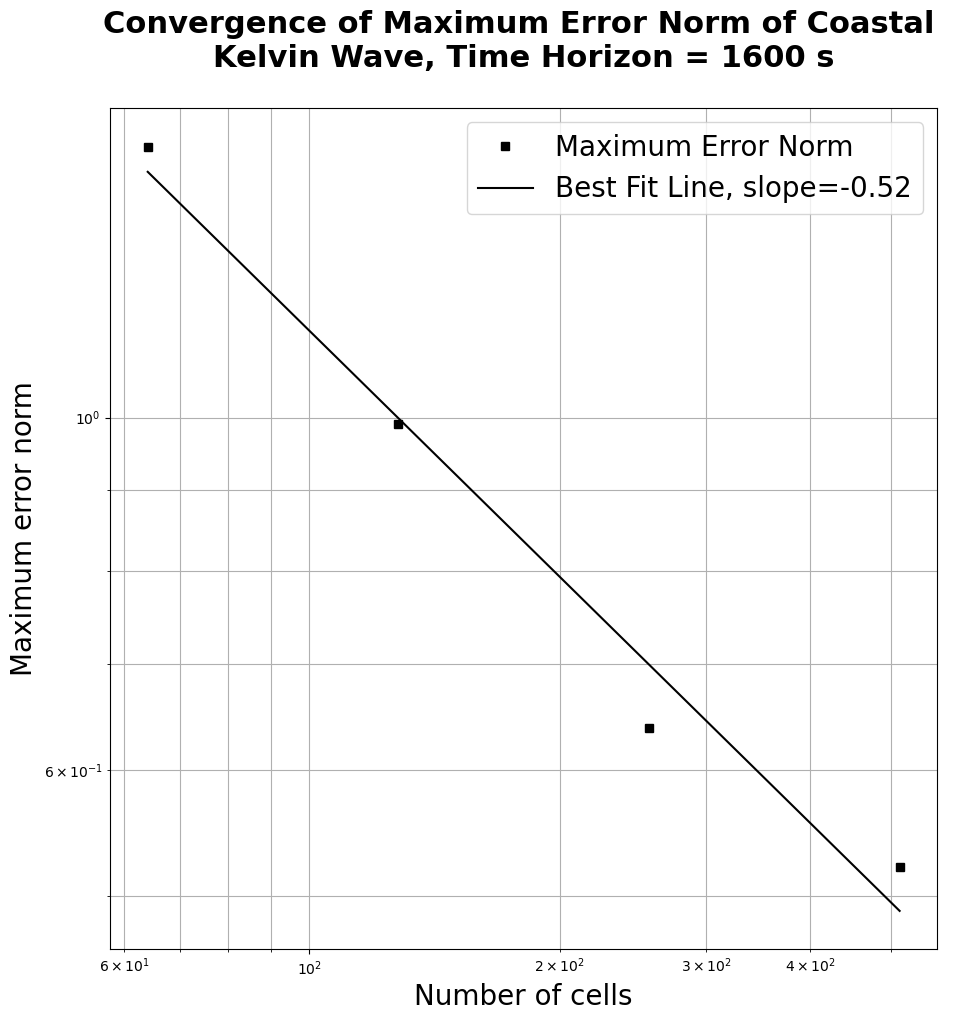

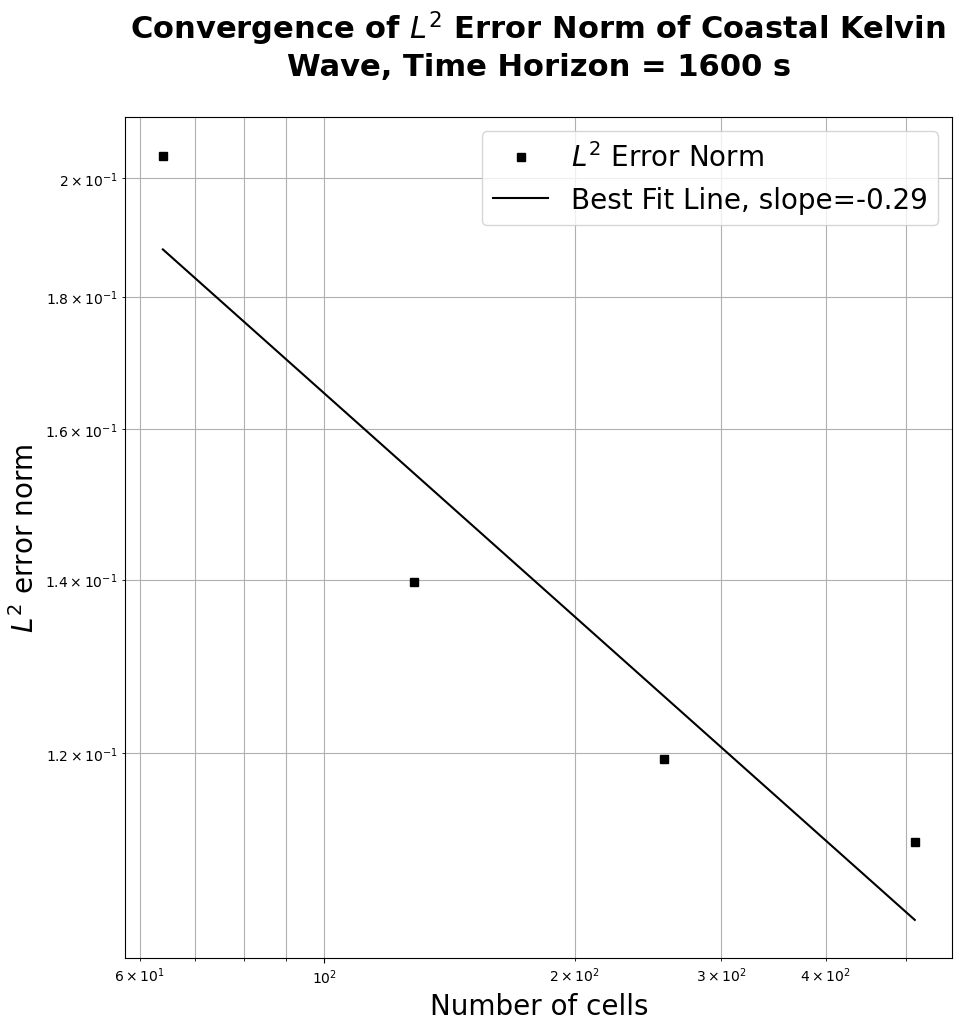

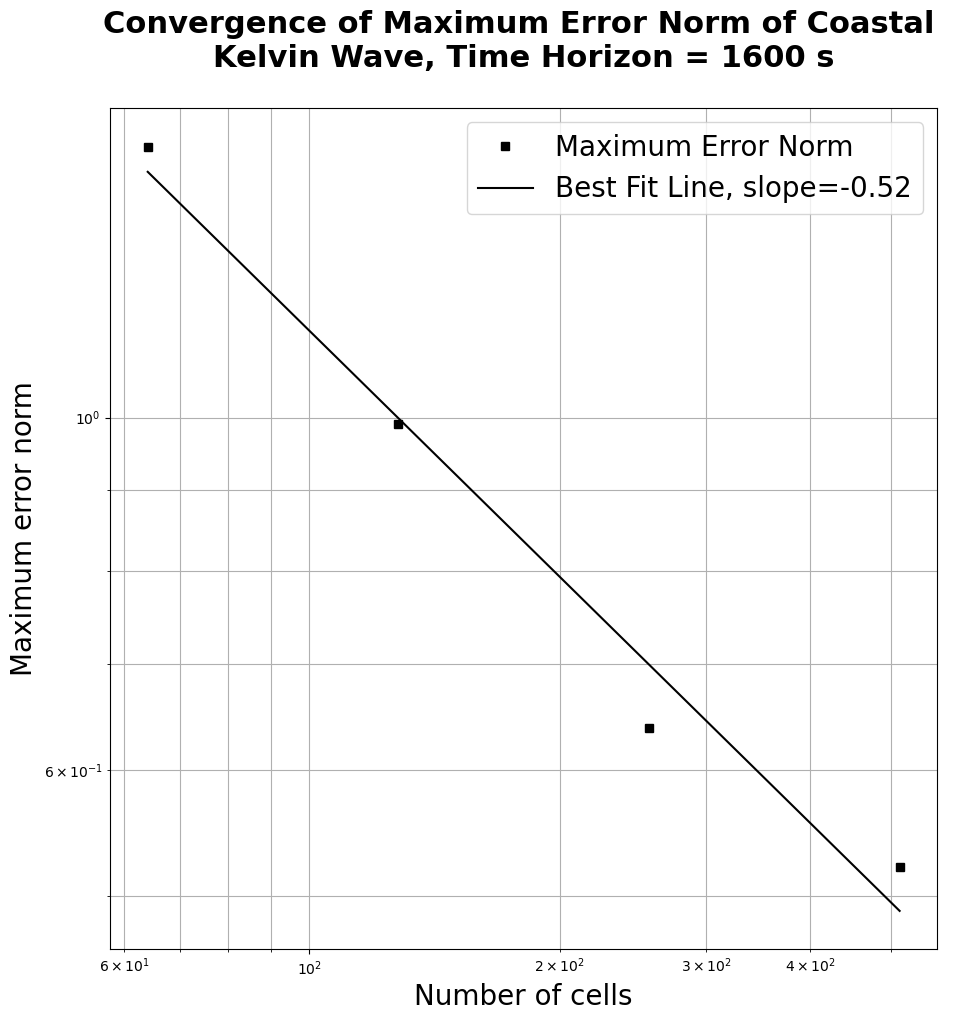

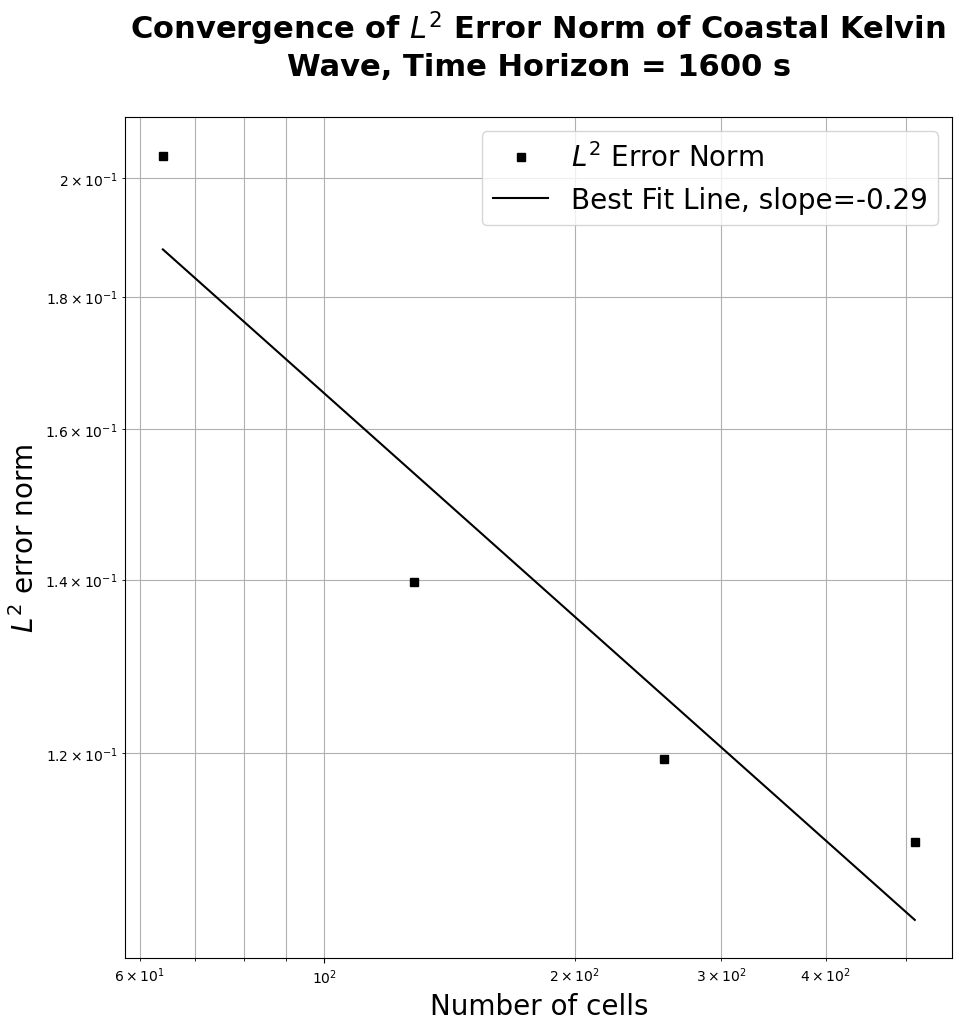

(Figure(PyObject <Figure size 900x900 with 1 Axes>), PyObject <AxesSubplot: title={'center': 'Convergence of $L^2$ Error Norm of Coastal Kelvin \nWave, Time Horizon = 1600 s\n'}, xlabel='Number of cells', ylabel='$L^2$ error norm'>)

In [8]:
convergence_test("NonPeriodic_x",
            CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
            "Coastal Kelvin Wave",
            kelvin_test, "CPU", 
            write_data=false, show_plots=true)

In [67]:
function readconvergencefile(periodicity, device, T)
    fname = CODE_ROOT * "output/simulation_convergence/coastal_kelvinwave/$periodicity/$device/timehorizon_$(T)/"
    fname = filter(x->x[end-3:end] == ".txt", readdir(fname, join=true))[end]
    return readdlm(fname), fname
end

readconvergencefile (generic function with 1 method)

In [72]:
T = 20000
data, fname = readconvergencefile("NonPeriodic_x", "CPU", T)
data[1,:], data[3]

([10000.0, 12100.0, 14400.0, 16900.0, 19600.0, 22500.0], 0.0015521633527742788)

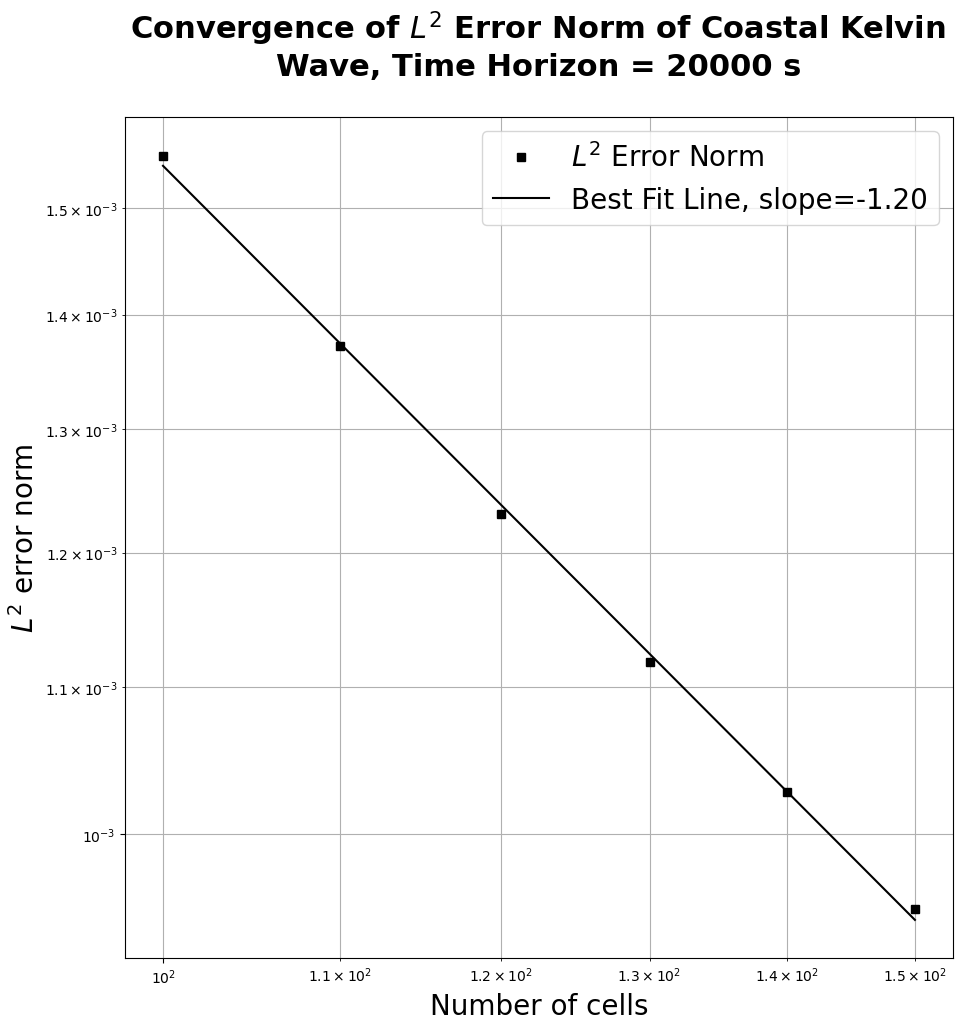

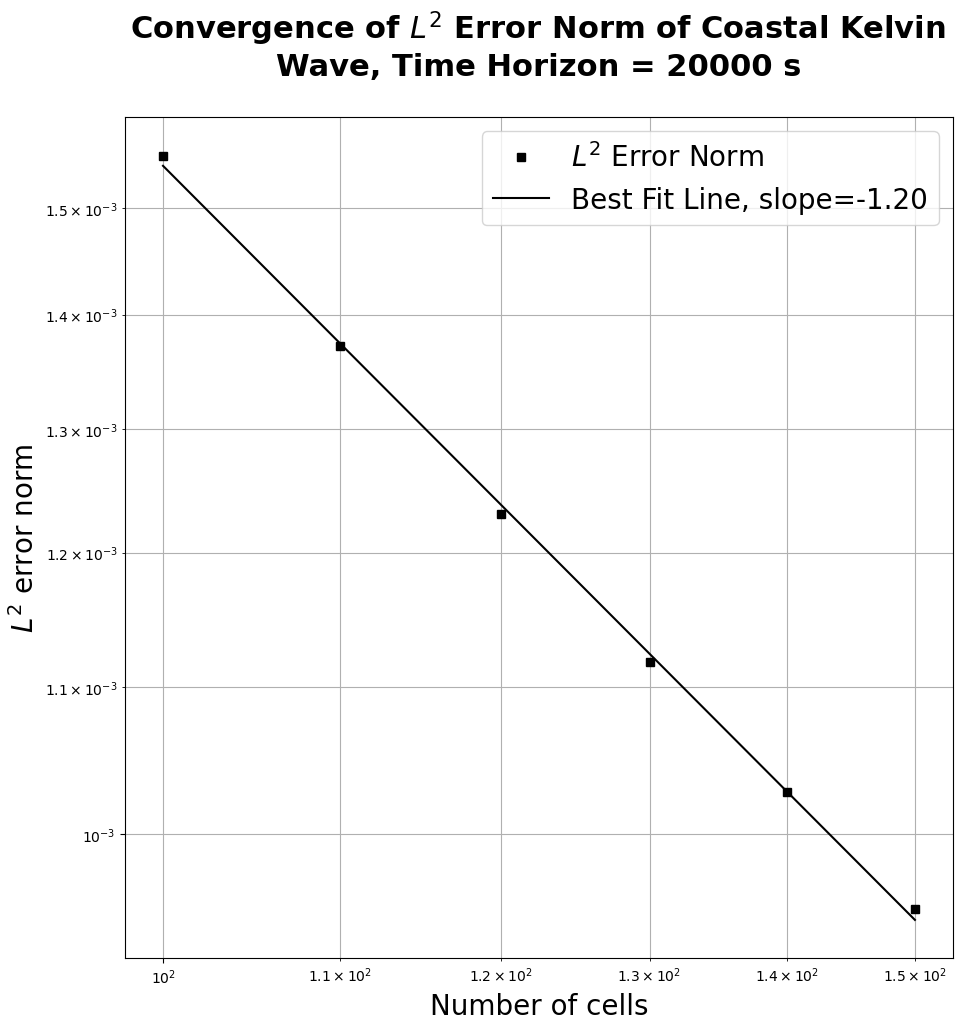

In [88]:
fig, ax = convergenceplot(sqrt.(data[1,:]), data[3,:], "\$L^2\$", T, 2)
fig.savefig("$(fname)_convergence.png", bbox_inches="tight")

# GPU version

In [6]:
import CUDA

In [18]:
function boundaryConditionCUDAKernel!(nEdges, boundaryEdge, gravity, H, lateralProfile,
                                        yEdge, lYedge, xEdge, R, normalVelocityCurrent,
                                        angleEdge, t)
    iEdge = (CUDA.blockIdx().x - 1) * CUDA.blockDim().x + CUDA.threadIdx().x
    if iEdge <= nEdges
        if boundaryEdge[iEdge] == 1
            c = CUDA.sqrt(gravity * H)
            v = c * lateralProfile(yEdge[iEdge] .+ c*t, lYedge) * CUDA.exp(-xEdge[iEdge]/R)
            normalVelocityCurrent[iEdge] = v*CUDA.sin(angleEdge[iEdge])
        end
    end

    return
end

boundaryConditionCUDAKernel! (generic function with 1 method)

In [21]:
function kelvin_test_cuda(mesh_directory, base_mesh_file_name, mesh_file_name, periodicity, T; plot=false)
    mpasOcean = MPAS_Ocean(mesh_directory,base_mesh_file_name,mesh_file_name, periodicity=periodicity)
        
    meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)
    meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)
    c = sqrt(mpasOcean.gravity*meanFluidThicknessH)
    rossbyRadiusR = c/meanCoriolisParameterf
    
    println("simulating for T: ", T)
    lYedge = maximum(mpasOcean.yEdge) - minimum(mpasOcean.yEdge)
    

    function lateralProfilePeriodicCUDA(y, lYedge)
        return 1e-3*CUDA.cos(y/lYedge * 4 * CUDA.pi)
    end
    
    function kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t=0)
        v = sqrt(mpasOcean.gravity*meanFluidThicknessH) * lateralProfilePeriodicCUDA(mpasOcean.yEdge[iEdge] .+ c*t, lYedge) * exp(-mpasOcean.xEdge[iEdge]/rossbyRadiusR)
        return v*sin(mpasOcean.angleEdge[iEdge])
    end

    function kelvinWaveExactSSH(mpasOcean, iCell, t=0)
        return - meanFluidThicknessH * lateralProfilePeriodicCUDA(mpasOcean.yCell[iCell] .+ c*t, lYedge) * exp(-mpasOcean.xCell[iCell]/rossbyRadiusR)
    end

    function kelvinWaveExactSolution!(mpasOcean, t=0)
        for iCell in 1:mpasOcean.nCells
            mpasOcean.sshCurrent[iCell] = kelvinWaveExactSSH(mpasOcean, iCell, t)
        end

        for iEdge in 1:mpasOcean.nEdges
            mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
        end
    end

    function boundaryConditionCUDA!(mpasOcean, t)
        CUDA.@cuda blocks=cld(mpasOcean.nEdges, 1024) threads=1024 maxregs=64 boundaryConditionCUDAKernel!(
            mpasOcean.nEdges, mpasOcean.boundaryEdge, mpasOcean.gravity, meanFluidThicknessH, lateralProfilePeriodicCUDA,
            mpasOcean.yEdge, lYedge, mpasOcean.xEdge, rossbyRadiusR, mpasOcean.normalVelocityCurrent, 
            mpasOcean.angleEdge, t
        )
    end
    
    moveArrays!(mpasOcean, Array)
    kelvinWaveExactSolution!(mpasOcean)
        
    nSaves = 1
    mpasOcean.dt = 0.1 * mpasOcean.dcEdge[1] / c
    saveInterval = round(T/mpasOcean.dt)
    mpasOcean.dt = T / saveInterval
    
    sshOverTimeNumerical = zeros(Float64, (nSaves, mpasOcean.nCells))
    sshOverTimeExact = zeros(Float64, (nSaves, mpasOcean.nCells))
    
    println("dx ", mpasOcean.dcEdge[1])
    println("dt ", mpasOcean.dt)
    
    moveArrays!(mpasOcean, CUDA.CuArray)
    t = 0
    for i in 1:nSaves
        for j in 1:saveInterval

            calculate_normal_velocity_tendency_cuda!(mpasOcean)
            update_normal_velocity_by_tendency_cuda!(mpasOcean)

            boundaryConditionCUDA!(mpasOcean, t)

            calculate_ssh_tendency_cuda!(mpasOcean)
            update_ssh_by_tendency_cuda!(mpasOcean)

            t += mpasOcean.dt
        end
        sshOverTimeNumerical[i,:] .= mpasOcean.sshCurrent[:]
    end
    
    moveArrays!(mpasOcean, Array)
    if plot
        fig, ax, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
        fig.suptitle("numerical solution")
        display(fig)
    end
    
    t = 0
    for iCell = 1:mpasOcean.nCells
        sshOverTimeExact[1,iCell] = kelvinWaveExactSSH(mpasOcean, iCell, T)
    end
    
    if plot
        fig, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:])
        fig.suptitle("exact solution")
        display(fig)
        
        fig, ax, _ = heatMapMesh(mpasOcean, sshOverTimeExact[end,:] - sshOverTimeNumerical[end,:])
        fig.suptitle("difference")
        display(fig)
    end
    
    error = sshOverTimeNumerical .- sshOverTimeExact
    MaxErrorNorm = norm(error, Inf)
    L2ErrorNorm = norm(error/sqrt(float(mpasOcean.nCells)))
    
    return mpasOcean.gridSpacingMagnitude, MaxErrorNorm, L2ErrorNorm
end

kelvin_test_cuda (generic function with 1 method)

simulating for T: 20000
dx 78124.99999999921
dt 79.05138339920948


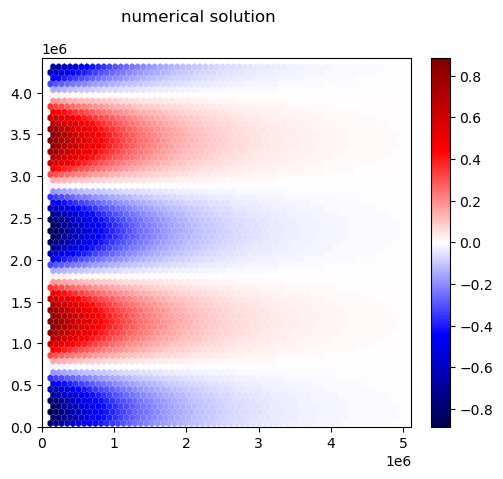

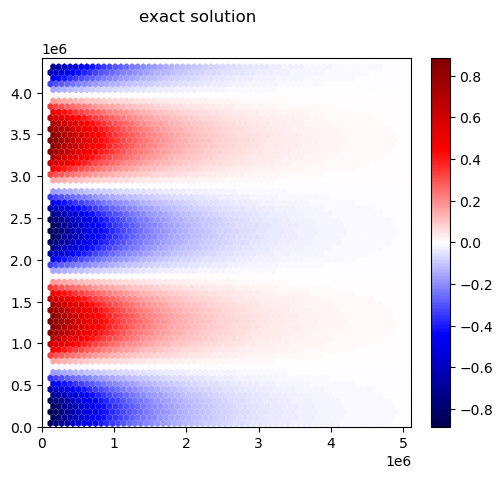

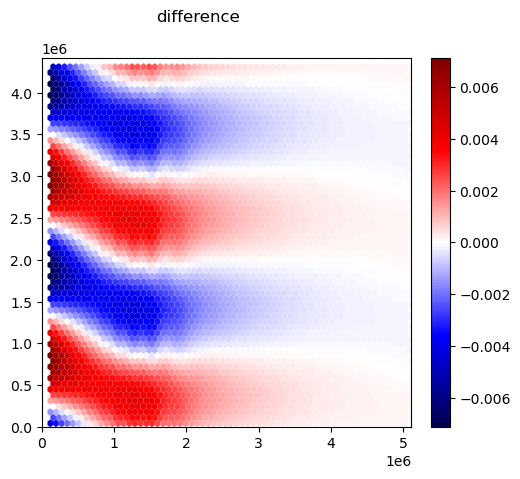

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007ff72387df90.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/rrs/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


(78125.00000000023, 0.007141428993815424, 0.001905924480879386)

In [20]:
T = 20000
nCellsX = 64
kelvin_test_cuda(
    CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
    "culled_mesh_$nCellsX.nc", "mesh_$nCellsX.nc", "NonPeriodic_x", T, plot=true)

running test 1 of 6
simulating for T: 20000
dx 50000.0
dt 50.505050505050505
running test 2 of 6
simulating for T: 20000
dx 45454.545454999155
dt 45.87155963302752
running test 3 of 6
simulating for T: 20000
dx 41666.66666700073
dt 42.10526315789474
running test 4 of 6
simulating for T: 20000
dx 38461.53846200055
dt 38.83495145631068
running test 5 of 6
simulating for T: 20000
dx 35714.28571399953
dt 36.101083032490976
running test 6 of 6
simulating for T: 20000
dx 33333.333333000664
dt 33.67003367003367


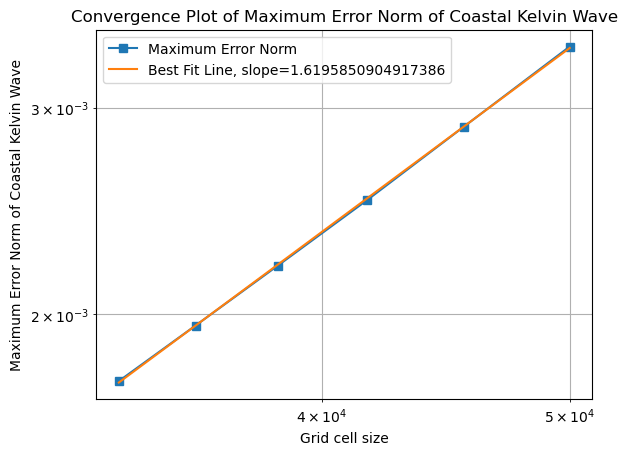

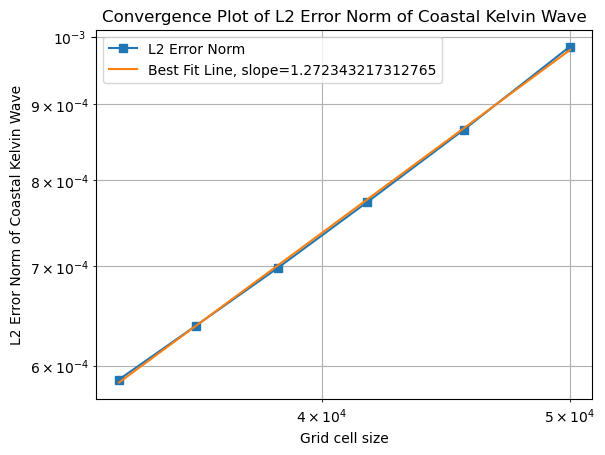

In [22]:
convergence_test("NonPeriodic_x",
            CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
            "Coastal Kelvin Wave",
            kelvin_test_cuda)

In [539]:
str = "0.213703597
0.166772736
0.165004856
0.162752072
0.163046855
0.162614586
0.163091705
0.162566552
0.171755812
0.162937786"

"0.213703597\n0.166772736\n0.165004856\n0.162752072\n0.163046855\n0.162614586\n0.163091705\n0.162566552\n0.171755812\n0.162937786"

In [540]:
arrstr = split(str, "\n")

10-element Vector{SubString{String}}:
 "0.213703597"
 "0.166772736"
 "0.165004856"
 "0.162752072"
 "0.163046855"
 "0.162614586"
 "0.163091705"
 "0.162566552"
 "0.171755812"
 "0.162937786"

In [542]:
arr = map(x -> parse(Float64, x), arrstr)

10-element Vector{Float64}:
 0.213703597
 0.166772736
 0.165004856
 0.162752072
 0.163046855
 0.162614586
 0.163091705
 0.162566552
 0.171755812
 0.162937786

In [549]:
sum(arr)/length(arr) / 24 * 1e6

7059.360654166667

In [546]:
pyunopt = 2.095

2.095

In [548]:
pyunopt/24 * 1e6

87291.66666666667